In [1]:
## mount drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install snntorch
!pip install segmentation-models-pytorch

In [3]:
import os
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

import cv2
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from pathlib import Path
from tqdm import tqdm
import albumentations as A
from albumentations.pytorch import ToTensorV2
import matplotlib.pyplot as plt
from sklearn.metrics import matthews_corrcoef
from torchvision import models
import snntorch as snn
from snntorch import surrogate
from snntorch import utils
import gc
import segmentation_models_pytorch as smp

# ==========================================
# 1. CONFIGURATION (STABLE MODE)
# ==========================================
CONFIG = {
    "base_dir": "/content/drive/MyDrive/GlacierHack_practice/Train",
    "project_dir": "/content/drive/MyDrive/Glacier_SNN_Project_vggnet16",
    "model_type": "SNN",

    # OPTIMIZED FOR STABILITY
    "time_steps": 6,       # Reduced T=4 to save memory (VGG is heavy!)
    "beta": 0.9,
    "epochs": 30,
    "batch_size": 1,       # Batch Size 2 is safe for VGG+SNN
    "lr": 1e-4,
    "num_workers": 2,
    "device": torch.device("cuda" if torch.cuda.is_available() else "cpu")
}

torch.cuda.empty_cache()
gc.collect()
os.makedirs(CONFIG['project_dir'], exist_ok=True)

def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)

set_seed(42)

# ==========================================
# 2. DATASET
# ==========================================
class GlacierDataset(Dataset):
    def __init__(self, base_dir, transform=None):
        self.base_dir = Path(base_dir)
        self.band_dirs = [self.base_dir / f"Band{i}" for i in range(1, 6)]
        self.label_dir = self.base_dir / "labels"
        self.ids = sorted([p.stem for p in self.band_dirs[0].glob("*.tif")])
        self.transform = transform

    def __len__(self): return len(self.ids)

    def __getitem__(self, idx):
        img_id = self.ids[idx]
        bands = [cv2.imread(str(d / f"{img_id}.tif"), cv2.IMREAD_UNCHANGED).astype(np.float32) for d in self.band_dirs]
        image = np.stack(bands, axis=-1)
        label = cv2.imread(str(self.label_dir / f"{img_id}.tif"), cv2.IMREAD_UNCHANGED)
        if label.ndim == 3: label = cv2.cvtColor(label, cv2.COLOR_BGR2GRAY)
        mask = np.zeros_like(label, dtype=np.uint8)
        mask[label == 85] = 1; mask[label == 170] = 2; mask[label == 255] = 3

        p02, p98 = np.percentile(image, 2), np.percentile(image, 98)
        image = np.clip(image, p02, p98)
        image = (image - image.min()) / (image.max() - image.min() + 1e-6)

        if self.transform:
            aug = self.transform(image=image, mask=mask)
            return aug["image"].float(), torch.tensor(aug["mask"]).long()
        return torch.tensor(image.transpose(2,0,1)).float(), torch.tensor(mask).long()

train_transform = A.Compose([
    A.HorizontalFlip(p=0.5), A.VerticalFlip(p=0.5), A.RandomRotate90(p=0.5),
    A.GridDistortion(p=0.3),
    ToTensorV2(),
])
val_transform = A.Compose([ToTensorV2()])

full_ds = GlacierDataset(CONFIG['base_dir'], transform=train_transform)
val_len = int(len(full_ds)*0.2)
train_ds, val_ds = random_split(full_ds, [len(full_ds)-val_len, val_len], generator=torch.Generator().manual_seed(42))
val_ds.dataset.transform = val_transform

train_loader = DataLoader(train_ds, batch_size=CONFIG['batch_size'], shuffle=True, num_workers=2)
val_loader = DataLoader(val_ds, batch_size=CONFIG['batch_size'], shuffle=False, num_workers=2)

# ==========================================
# 3. ARCHITECTURE (VGG16 U-Net)
# ==========================================
class UnifiedEncoder(nn.Module):
    def __init__(self, mode="CNN"):
        super().__init__()
        vgg = models.vgg16_bn(weights=models.VGG16_BN_Weights.DEFAULT)
        features = list(vgg.features.children())

        old_conv0 = features[0]
        new_conv0 = nn.Conv2d(5, 64, kernel_size=3, padding=1)
        with torch.no_grad():
            new_conv0.weight[:, :3] = old_conv0.weight
            new_conv0.weight[:, 3:] = old_conv0.weight[:, :2]
        features[0] = new_conv0

        self.layers = nn.ModuleList()
        spike_grad = surrogate.atan()

        for layer in features:
            if isinstance(layer, nn.ReLU):
                if mode == "SNN":
                    # init_hidden=True allows statefulness, but we must reset manually!
                    self.layers.append(snn.Leaky(beta=CONFIG['beta'], spike_grad=spike_grad, init_hidden=True))
                else:
                    self.layers.append(layer)
            else:
                self.layers.append(layer)

    def forward(self, x):
        out = x
        feats = []
        for i in range(6): out = self.layers[i](out)
        feats.append(out) # x1
        out = self.layers[6](out)

        for i in range(7, 13): out = self.layers[i](out)
        feats.append(out) # x2
        out = self.layers[13](out)

        for i in range(14, 23): out = self.layers[i](out)
        feats.append(out) # x3
        out = self.layers[23](out)

        for i in range(24, 33): out = self.layers[i](out)
        feats.append(out) # x4
        out = self.layers[33](out)

        for i in range(34, 43): out = self.layers[i](out)
        feats.append(out) # x5
        out = self.layers[43](out) # Bottleneck

        feats.append(out)
        return feats

class UnifiedDecoder(nn.Module):
    def __init__(self, mode="CNN"):
        super().__init__()
        spike_grad = surrogate.atan()

        def block(in_c, out_c):
            act = snn.Leaky(beta=CONFIG['beta'], spike_grad=spike_grad, init_hidden=True) if mode == "SNN" else nn.ReLU(inplace=True)
            return nn.Sequential(
                nn.Conv2d(in_c, out_c, 3, padding=1), nn.BatchNorm2d(out_c), act
            )

        self.up5 = nn.ConvTranspose2d(512, 512, 2, 2)
        self.dec5 = block(1024, 512)
        self.up4 = nn.ConvTranspose2d(512, 512, 2, 2)
        self.dec4 = block(1024, 512)
        self.up3 = nn.ConvTranspose2d(512, 256, 2, 2)
        self.dec3 = block(512, 256)
        self.up2 = nn.ConvTranspose2d(256, 128, 2, 2)
        self.dec2 = block(256, 128)
        self.up1 = nn.ConvTranspose2d(128, 64, 2, 2)
        self.dec1 = block(128, 64)
        self.final = nn.Conv2d(64, 4, 1)

    def forward(self, x, enc):
        u5 = self.up5(x)
        if u5.shape != enc[4].shape: u5 = F.interpolate(u5, size=enc[4].shape[2:])
        d5 = self.dec5(torch.cat([enc[4], u5], 1))

        u4 = self.up4(d5)
        if u4.shape != enc[3].shape: u4 = F.interpolate(u4, size=enc[3].shape[2:])
        d4 = self.dec4(torch.cat([enc[3], u4], 1))

        u3 = self.up3(d4)
        if u3.shape != enc[2].shape: u3 = F.interpolate(u3, size=enc[2].shape[2:])
        d3 = self.dec3(torch.cat([enc[2], u3], 1))

        u2 = self.up2(d3)
        if u2.shape != enc[1].shape: u2 = F.interpolate(u2, size=enc[1].shape[2:])
        d2 = self.dec2(torch.cat([enc[1], u2], 1))

        u1 = self.up1(d2)
        if u1.shape != enc[0].shape: u1 = F.interpolate(u1, size=enc[0].shape[2:])
        d1 = self.dec1(torch.cat([enc[0], u1], 1))

        return self.final(d1)

class UnifiedUNet(nn.Module):
    def __init__(self, mode="CNN"):
        super().__init__()
        self.mode = mode
        self.encoder = UnifiedEncoder(mode)
        self.decoder = UnifiedDecoder(mode)

    def forward(self, x):
        # Note: No reset here. We do it manually in the loop.
        if self.mode == "SNN":
            spk_rec = []
            for step in range(CONFIG['time_steps']):
                enc_feats = self.encoder(x)
                out = self.decoder(enc_feats[-1], enc_feats[:-1])
                spk_rec.append(out)
            return torch.stack(spk_rec).mean(0)
        else:
            enc_feats = self.encoder(x)
            return self.decoder(enc_feats[-1], enc_feats[:-1])

# ==========================================
# 4. TRAINING LOOP
# ==========================================
def manual_reset(model):
    """Crucial: Force reset all SNN layers"""
    for m in model.modules():
        if hasattr(m, "reset_mem"): m.reset_mem()

import segmentation_models_pytorch as smp
class HybridLoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.ce = nn.CrossEntropyLoss()
        self.lovasz = smp.losses.LovaszLoss(mode='multiclass', per_image=True)
    def forward(self, inputs, targets):
        return 0.5 * self.ce(inputs, targets) + 0.5 * self.lovasz(inputs, targets)

def save_vis(history, epoch):
    plt.figure(figsize=(10, 5))
    plt.subplot(1,2,1); plt.plot(history['loss']); plt.title(f"{CONFIG['model_type']} Loss")
    plt.subplot(1,2,2); plt.plot(history['mcc']); plt.title(f"{CONFIG['model_type']} MCC")
    plt.savefig(f"{CONFIG['project_dir']}/{CONFIG['model_type']}_history.png")
    plt.close()

# INITIALIZE
model = UnifiedUNet(mode=CONFIG['model_type']).to(CONFIG['device'])
optimizer = optim.AdamW(model.parameters(), lr=CONFIG['lr'])
criterion = HybridLoss()

# REMOVED SCALER (Running in FP32 for stability)

best_mcc = -1.0
history = {'loss': [], 'mcc': []}

print(f"🔥 Starting SNN Training (Stable Mode: BS={CONFIG['batch_size']}, T={CONFIG['time_steps']})...")

for epoch in range(CONFIG['epochs']):
    model.train()
    running_loss = 0

    pbar = tqdm(train_loader, desc=f"Ep {epoch+1}")
    for imgs, masks in pbar:
        imgs, masks = imgs.to(CONFIG['device']), masks.to(CONFIG['device']).long()

        # 1. FORCE RESET (Solves "Backward 2nd Time" Error)
        manual_reset(model)

        optimizer.zero_grad()

        # 2. Standard Forward (No Autocast)
        out = model(imgs)
        loss = criterion(out, masks)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        pbar.set_postfix({'loss': loss.item()})

    avg_loss = running_loss / len(train_loader)
    history['loss'].append(avg_loss)

    # Validation
    model.eval()
    preds, targets = [], []
    with torch.no_grad():
        for imgs, masks in val_loader:
            imgs = imgs.to(CONFIG['device'])
            manual_reset(model) # Reset before validation inference too

            out = model(imgs)
            preds.append(out.argmax(1).cpu())
            targets.append(masks.cpu())

    mcc = matthews_corrcoef(torch.cat(targets).numpy().flatten(), torch.cat(preds).numpy().flatten())
    history['mcc'].append(mcc)

    print(f"Ep {epoch+1} | Loss: {avg_loss:.4f} | Val MCC: {mcc:.4f}")
    save_vis(history, epoch+1)

    if mcc > best_mcc:
        best_mcc = mcc
        torch.save(model.state_dict(), f"{CONFIG['project_dir']}/best_{CONFIG['model_type']}_Fixed.pth")
        print("✅ Saved Best Model!")

print(f"🏁 Finished. Best MCC: {best_mcc:.4f}")

🔥 Starting SNN Training (Stable Mode: BS=1, T=6)...


Ep 1:   0%|          | 0/20 [00:00<?, ?it/s]/tmp/ipython-input-1514054296.py:81: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return aug["image"].float(), torch.tensor(aug["mask"]).long()
/tmp/ipython-input-1514054296.py:81: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return aug["image"].float(), torch.tensor(aug["mask"]).long()
Ep 1: 100%|██████████| 20/20 [00:30<00:00,  1.51s/it, loss=1.04]
/tmp/ipython-input-1514054296.py:81: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return aug["image"].float(), torch.tensor(aug["mask"]).long()


Ep 1 | Loss: 1.0699 | Val MCC: 0.1567
✅ Saved Best Model!


Ep 2:   0%|          | 0/20 [00:00<?, ?it/s]/tmp/ipython-input-1514054296.py:81: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return aug["image"].float(), torch.tensor(aug["mask"]).long()
/tmp/ipython-input-1514054296.py:81: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return aug["image"].float(), torch.tensor(aug["mask"]).long()
Ep 2: 100%|██████████| 20/20 [00:30<00:00,  1.51s/it, loss=0.97]
/tmp/ipython-input-1514054296.py:81: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return aug["image"].float(), torch.tensor(aug["mask"]).long()


Ep 2 | Loss: 1.0079 | Val MCC: 0.2405
✅ Saved Best Model!


Ep 3:   0%|          | 0/20 [00:00<?, ?it/s]/tmp/ipython-input-1514054296.py:81: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return aug["image"].float(), torch.tensor(aug["mask"]).long()
/tmp/ipython-input-1514054296.py:81: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return aug["image"].float(), torch.tensor(aug["mask"]).long()
Ep 3: 100%|██████████| 20/20 [00:30<00:00,  1.54s/it, loss=0.954]
/tmp/ipython-input-1514054296.py:81: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return aug["image"].float(), torch.tensor(aug["mask"]).long()

Ep 3 | Loss: 0.9652 | Val MCC: 0.1517


Ep 4:   0%|          | 0/20 [00:00<?, ?it/s]/tmp/ipython-input-1514054296.py:81: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return aug["image"].float(), torch.tensor(aug["mask"]).long()
/tmp/ipython-input-1514054296.py:81: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return aug["image"].float(), torch.tensor(aug["mask"]).long()
Ep 4: 100%|██████████| 20/20 [00:31<00:00,  1.56s/it, loss=0.904]
/tmp/ipython-input-1514054296.py:81: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return aug["image"].float(), torch.tensor(aug["mask"]).long()

Ep 4 | Loss: 0.9315 | Val MCC: 0.3077
✅ Saved Best Model!


Ep 5:   0%|          | 0/20 [00:00<?, ?it/s]/tmp/ipython-input-1514054296.py:81: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return aug["image"].float(), torch.tensor(aug["mask"]).long()
/tmp/ipython-input-1514054296.py:81: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return aug["image"].float(), torch.tensor(aug["mask"]).long()
Ep 5: 100%|██████████| 20/20 [00:30<00:00,  1.55s/it, loss=0.826]
/tmp/ipython-input-1514054296.py:81: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return aug["image"].float(), torch.tensor(aug["mask"]).long()

Ep 5 | Loss: 0.9082 | Val MCC: 0.2944


Ep 6:   0%|          | 0/20 [00:00<?, ?it/s]/tmp/ipython-input-1514054296.py:81: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return aug["image"].float(), torch.tensor(aug["mask"]).long()
/tmp/ipython-input-1514054296.py:81: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return aug["image"].float(), torch.tensor(aug["mask"]).long()
Ep 6: 100%|██████████| 20/20 [00:31<00:00,  1.55s/it, loss=0.898]
/tmp/ipython-input-1514054296.py:81: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return aug["image"].float(), torch.tensor(aug["mask"]).long()

Ep 6 | Loss: 0.8878 | Val MCC: 0.2934


Ep 7:   0%|          | 0/20 [00:00<?, ?it/s]/tmp/ipython-input-1514054296.py:81: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return aug["image"].float(), torch.tensor(aug["mask"]).long()
/tmp/ipython-input-1514054296.py:81: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return aug["image"].float(), torch.tensor(aug["mask"]).long()
Ep 7: 100%|██████████| 20/20 [00:31<00:00,  1.55s/it, loss=0.865]
/tmp/ipython-input-1514054296.py:81: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return aug["image"].float(), torch.tensor(aug["mask"]).long()

Ep 7 | Loss: 0.8639 | Val MCC: 0.3130
✅ Saved Best Model!


Ep 8:   0%|          | 0/20 [00:00<?, ?it/s]/tmp/ipython-input-1514054296.py:81: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return aug["image"].float(), torch.tensor(aug["mask"]).long()
/tmp/ipython-input-1514054296.py:81: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return aug["image"].float(), torch.tensor(aug["mask"]).long()
Ep 8: 100%|██████████| 20/20 [00:30<00:00,  1.55s/it, loss=0.807]
/tmp/ipython-input-1514054296.py:81: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return aug["image"].float(), torch.tensor(aug["mask"]).long()

Ep 8 | Loss: 0.8487 | Val MCC: 0.3293
✅ Saved Best Model!


Ep 9:   0%|          | 0/20 [00:00<?, ?it/s]/tmp/ipython-input-1514054296.py:81: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return aug["image"].float(), torch.tensor(aug["mask"]).long()
/tmp/ipython-input-1514054296.py:81: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return aug["image"].float(), torch.tensor(aug["mask"]).long()
Ep 9: 100%|██████████| 20/20 [00:31<00:00,  1.55s/it, loss=0.809]
/tmp/ipython-input-1514054296.py:81: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return aug["image"].float(), torch.tensor(aug["mask"]).long()

Ep 9 | Loss: 0.8297 | Val MCC: 0.3387
✅ Saved Best Model!


Ep 10:   0%|          | 0/20 [00:00<?, ?it/s]/tmp/ipython-input-1514054296.py:81: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return aug["image"].float(), torch.tensor(aug["mask"]).long()
/tmp/ipython-input-1514054296.py:81: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return aug["image"].float(), torch.tensor(aug["mask"]).long()
Ep 10: 100%|██████████| 20/20 [00:31<00:00,  1.55s/it, loss=0.874]
/tmp/ipython-input-1514054296.py:81: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return aug["image"].float(), torch.tensor(aug["mask"]).long

Ep 10 | Loss: 0.8169 | Val MCC: 0.3512
✅ Saved Best Model!


Ep 11:   0%|          | 0/20 [00:00<?, ?it/s]/tmp/ipython-input-1514054296.py:81: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return aug["image"].float(), torch.tensor(aug["mask"]).long()
/tmp/ipython-input-1514054296.py:81: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return aug["image"].float(), torch.tensor(aug["mask"]).long()
Ep 11: 100%|██████████| 20/20 [00:31<00:00,  1.55s/it, loss=0.833]
/tmp/ipython-input-1514054296.py:81: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return aug["image"].float(), torch.tensor(aug["mask"]).long

Ep 11 | Loss: 0.8024 | Val MCC: 0.3440


Ep 12:   0%|          | 0/20 [00:00<?, ?it/s]/tmp/ipython-input-1514054296.py:81: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return aug["image"].float(), torch.tensor(aug["mask"]).long()
/tmp/ipython-input-1514054296.py:81: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return aug["image"].float(), torch.tensor(aug["mask"]).long()
Ep 12: 100%|██████████| 20/20 [00:31<00:00,  1.55s/it, loss=0.795]
/tmp/ipython-input-1514054296.py:81: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return aug["image"].float(), torch.tensor(aug["mask"]).long

Ep 12 | Loss: 0.7856 | Val MCC: 0.3778
✅ Saved Best Model!


Ep 13:   0%|          | 0/20 [00:00<?, ?it/s]/tmp/ipython-input-1514054296.py:81: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return aug["image"].float(), torch.tensor(aug["mask"]).long()
/tmp/ipython-input-1514054296.py:81: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return aug["image"].float(), torch.tensor(aug["mask"]).long()
Ep 13: 100%|██████████| 20/20 [00:31<00:00,  1.57s/it, loss=0.799]
/tmp/ipython-input-1514054296.py:81: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return aug["image"].float(), torch.tensor(aug["mask"]).long

Ep 13 | Loss: 0.7712 | Val MCC: 0.3740


Ep 14:   0%|          | 0/20 [00:00<?, ?it/s]/tmp/ipython-input-1514054296.py:81: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return aug["image"].float(), torch.tensor(aug["mask"]).long()
/tmp/ipython-input-1514054296.py:81: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return aug["image"].float(), torch.tensor(aug["mask"]).long()
Ep 14: 100%|██████████| 20/20 [00:30<00:00,  1.55s/it, loss=0.782]
/tmp/ipython-input-1514054296.py:81: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return aug["image"].float(), torch.tensor(aug["mask"]).long

Ep 14 | Loss: 0.7549 | Val MCC: 0.3608


Ep 15:   0%|          | 0/20 [00:00<?, ?it/s]/tmp/ipython-input-1514054296.py:81: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return aug["image"].float(), torch.tensor(aug["mask"]).long()
/tmp/ipython-input-1514054296.py:81: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return aug["image"].float(), torch.tensor(aug["mask"]).long()
Ep 15: 100%|██████████| 20/20 [00:31<00:00,  1.55s/it, loss=0.788]
/tmp/ipython-input-1514054296.py:81: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return aug["image"].float(), torch.tensor(aug["mask"]).long

Ep 15 | Loss: 0.7400 | Val MCC: 0.3718


Ep 16:   0%|          | 0/20 [00:00<?, ?it/s]/tmp/ipython-input-1514054296.py:81: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return aug["image"].float(), torch.tensor(aug["mask"]).long()
/tmp/ipython-input-1514054296.py:81: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return aug["image"].float(), torch.tensor(aug["mask"]).long()
Ep 16: 100%|██████████| 20/20 [00:31<00:00,  1.55s/it, loss=0.703]
/tmp/ipython-input-1514054296.py:81: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return aug["image"].float(), torch.tensor(aug["mask"]).long

Ep 16 | Loss: 0.7258 | Val MCC: 0.3711


Ep 17:   0%|          | 0/20 [00:00<?, ?it/s]/tmp/ipython-input-1514054296.py:81: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return aug["image"].float(), torch.tensor(aug["mask"]).long()
/tmp/ipython-input-1514054296.py:81: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return aug["image"].float(), torch.tensor(aug["mask"]).long()
Ep 17: 100%|██████████| 20/20 [00:31<00:00,  1.55s/it, loss=0.766]
/tmp/ipython-input-1514054296.py:81: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return aug["image"].float(), torch.tensor(aug["mask"]).long

Ep 17 | Loss: 0.7138 | Val MCC: 0.3762


Ep 18:   0%|          | 0/20 [00:00<?, ?it/s]/tmp/ipython-input-1514054296.py:81: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return aug["image"].float(), torch.tensor(aug["mask"]).long()
/tmp/ipython-input-1514054296.py:81: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return aug["image"].float(), torch.tensor(aug["mask"]).long()
Ep 18: 100%|██████████| 20/20 [00:31<00:00,  1.55s/it, loss=0.644]
/tmp/ipython-input-1514054296.py:81: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return aug["image"].float(), torch.tensor(aug["mask"]).long

Ep 18 | Loss: 0.6996 | Val MCC: 0.4067
✅ Saved Best Model!


Ep 19:   0%|          | 0/20 [00:00<?, ?it/s]/tmp/ipython-input-1514054296.py:81: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return aug["image"].float(), torch.tensor(aug["mask"]).long()
/tmp/ipython-input-1514054296.py:81: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return aug["image"].float(), torch.tensor(aug["mask"]).long()
Ep 19: 100%|██████████| 20/20 [00:31<00:00,  1.55s/it, loss=0.65]
/tmp/ipython-input-1514054296.py:81: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return aug["image"].float(), torch.tensor(aug["mask"]).long(

Ep 19 | Loss: 0.6920 | Val MCC: 0.3396


Ep 20:   0%|          | 0/20 [00:00<?, ?it/s]/tmp/ipython-input-1514054296.py:81: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return aug["image"].float(), torch.tensor(aug["mask"]).long()
/tmp/ipython-input-1514054296.py:81: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return aug["image"].float(), torch.tensor(aug["mask"]).long()
Ep 20: 100%|██████████| 20/20 [00:31<00:00,  1.56s/it, loss=0.773]
/tmp/ipython-input-1514054296.py:81: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return aug["image"].float(), torch.tensor(aug["mask"]).long

Ep 20 | Loss: 0.6822 | Val MCC: 0.3797


Ep 21:   0%|          | 0/20 [00:00<?, ?it/s]/tmp/ipython-input-1514054296.py:81: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return aug["image"].float(), torch.tensor(aug["mask"]).long()
/tmp/ipython-input-1514054296.py:81: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return aug["image"].float(), torch.tensor(aug["mask"]).long()
Ep 21: 100%|██████████| 20/20 [00:31<00:00,  1.55s/it, loss=0.615]
/tmp/ipython-input-1514054296.py:81: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return aug["image"].float(), torch.tensor(aug["mask"]).long

Ep 21 | Loss: 0.6690 | Val MCC: 0.3554


Ep 22:   0%|          | 0/20 [00:00<?, ?it/s]/tmp/ipython-input-1514054296.py:81: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return aug["image"].float(), torch.tensor(aug["mask"]).long()
/tmp/ipython-input-1514054296.py:81: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return aug["image"].float(), torch.tensor(aug["mask"]).long()
Ep 22: 100%|██████████| 20/20 [00:31<00:00,  1.55s/it, loss=0.571]
/tmp/ipython-input-1514054296.py:81: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return aug["image"].float(), torch.tensor(aug["mask"]).long

Ep 22 | Loss: 0.6601 | Val MCC: 0.1604


Ep 23:   0%|          | 0/20 [00:00<?, ?it/s]/tmp/ipython-input-1514054296.py:81: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return aug["image"].float(), torch.tensor(aug["mask"]).long()
/tmp/ipython-input-1514054296.py:81: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return aug["image"].float(), torch.tensor(aug["mask"]).long()
Ep 23: 100%|██████████| 20/20 [00:31<00:00,  1.56s/it, loss=0.707]
/tmp/ipython-input-1514054296.py:81: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return aug["image"].float(), torch.tensor(aug["mask"]).long

Ep 23 | Loss: 0.6512 | Val MCC: 0.3726


Ep 24:   0%|          | 0/20 [00:00<?, ?it/s]/tmp/ipython-input-1514054296.py:81: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return aug["image"].float(), torch.tensor(aug["mask"]).long()
/tmp/ipython-input-1514054296.py:81: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return aug["image"].float(), torch.tensor(aug["mask"]).long()
Ep 24: 100%|██████████| 20/20 [00:31<00:00,  1.55s/it, loss=0.589]
/tmp/ipython-input-1514054296.py:81: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return aug["image"].float(), torch.tensor(aug["mask"]).long

Ep 24 | Loss: 0.6413 | Val MCC: 0.1458


Ep 25:   0%|          | 0/20 [00:00<?, ?it/s]/tmp/ipython-input-1514054296.py:81: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return aug["image"].float(), torch.tensor(aug["mask"]).long()
/tmp/ipython-input-1514054296.py:81: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return aug["image"].float(), torch.tensor(aug["mask"]).long()
Ep 25: 100%|██████████| 20/20 [00:31<00:00,  1.55s/it, loss=0.627]
/tmp/ipython-input-1514054296.py:81: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return aug["image"].float(), torch.tensor(aug["mask"]).long

Ep 25 | Loss: 0.6346 | Val MCC: 0.3416


Ep 26:   0%|          | 0/20 [00:00<?, ?it/s]/tmp/ipython-input-1514054296.py:81: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return aug["image"].float(), torch.tensor(aug["mask"]).long()
/tmp/ipython-input-1514054296.py:81: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return aug["image"].float(), torch.tensor(aug["mask"]).long()
Ep 26: 100%|██████████| 20/20 [00:31<00:00,  1.55s/it, loss=0.56]
/tmp/ipython-input-1514054296.py:81: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return aug["image"].float(), torch.tensor(aug["mask"]).long(

Ep 26 | Loss: 0.6242 | Val MCC: 0.3558


Ep 27:   0%|          | 0/20 [00:00<?, ?it/s]/tmp/ipython-input-1514054296.py:81: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return aug["image"].float(), torch.tensor(aug["mask"]).long()
/tmp/ipython-input-1514054296.py:81: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return aug["image"].float(), torch.tensor(aug["mask"]).long()
Ep 27: 100%|██████████| 20/20 [00:31<00:00,  1.55s/it, loss=0.664]
/tmp/ipython-input-1514054296.py:81: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return aug["image"].float(), torch.tensor(aug["mask"]).long

Ep 27 | Loss: 0.6234 | Val MCC: 0.3846


Ep 28:   0%|          | 0/20 [00:00<?, ?it/s]/tmp/ipython-input-1514054296.py:81: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return aug["image"].float(), torch.tensor(aug["mask"]).long()
/tmp/ipython-input-1514054296.py:81: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return aug["image"].float(), torch.tensor(aug["mask"]).long()
Ep 28: 100%|██████████| 20/20 [00:31<00:00,  1.56s/it, loss=0.577]
/tmp/ipython-input-1514054296.py:81: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return aug["image"].float(), torch.tensor(aug["mask"]).long

Ep 28 | Loss: 0.6156 | Val MCC: 0.3830


Ep 29:   0%|          | 0/20 [00:00<?, ?it/s]/tmp/ipython-input-1514054296.py:81: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return aug["image"].float(), torch.tensor(aug["mask"]).long()
/tmp/ipython-input-1514054296.py:81: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return aug["image"].float(), torch.tensor(aug["mask"]).long()
Ep 29: 100%|██████████| 20/20 [00:31<00:00,  1.55s/it, loss=0.619]
/tmp/ipython-input-1514054296.py:81: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return aug["image"].float(), torch.tensor(aug["mask"]).long

Ep 29 | Loss: 0.6101 | Val MCC: 0.3061


Ep 30:   0%|          | 0/20 [00:00<?, ?it/s]/tmp/ipython-input-1514054296.py:81: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return aug["image"].float(), torch.tensor(aug["mask"]).long()
/tmp/ipython-input-1514054296.py:81: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return aug["image"].float(), torch.tensor(aug["mask"]).long()
Ep 30: 100%|██████████| 20/20 [00:31<00:00,  1.55s/it, loss=0.667]
/tmp/ipython-input-1514054296.py:81: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return aug["image"].float(), torch.tensor(aug["mask"]).long

Ep 30 | Loss: 0.5978 | Val MCC: 0.3689
🏁 Finished. Best MCC: 0.4067


⏳ Loading SNN Model from /content/drive/MyDrive/Glacier_SNN_Project_vggnet16/best_SNN_Fixed.pth...
✅ Model Loaded Successfully!
🔍 Hunting for the best visual sample in validation set...
   ✨ Found new best! MCC: 0.3411


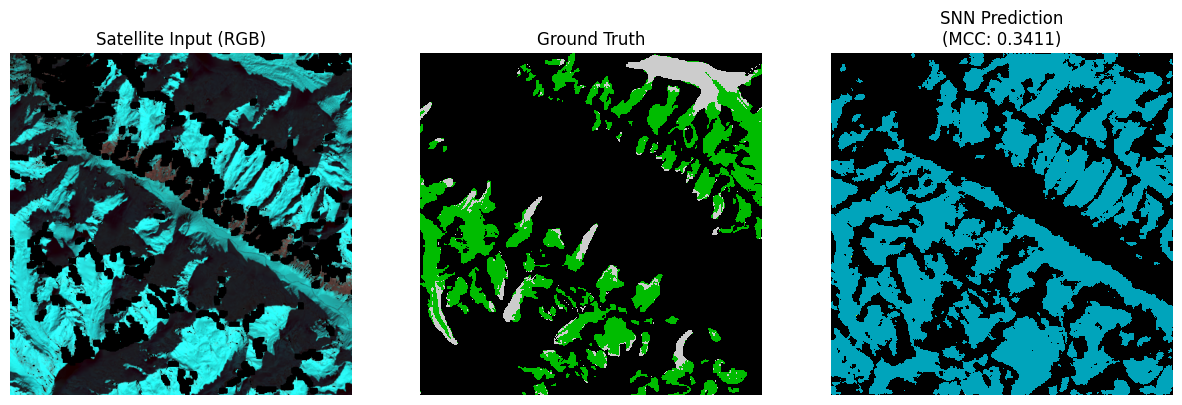

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset, random_split
from pathlib import Path
import cv2
import albumentations as A
from albumentations.pytorch import ToTensorV2
from sklearn.metrics import matthews_corrcoef
from torchvision import models
import snntorch as snn
from snntorch import surrogate
from snntorch import utils

# --- CONFIG ---
# Ensure this matches where your files are!
PROJECT_DIR = "/content/drive/MyDrive/Glacier_SNN_Project_vggnet16"
DATA_DIR = "/content/drive/MyDrive/GlacierHack_practice/Train"
MODEL_TYPE = "SNN" # Change to "SNN" to visualize the Spiking Model
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Path to the model file
MODEL_PATH = f"{PROJECT_DIR}/best_{MODEL_TYPE}_Fixed.pth"

# ==========================================
# 1. EXACT MODEL ARCHITECTURE (COPY-PASTE)
# ==========================================
# We must define the classes EXACTLY as they were during training
class UnifiedEncoder(nn.Module):
    def __init__(self, mode="CNN"):
        super().__init__()
        self.mode = mode
        vgg = models.vgg16_bn(weights=None) # No need to download weights for inference
        features = list(vgg.features.children())

        # input channel count (3 -> 5)
        old_conv0 = features[0]
        new_conv0 = nn.Conv2d(5, 64, kernel_size=3, padding=1)
        features[0] = new_conv0

        self.layers = nn.ModuleList()
        spike_grad = surrogate.atan()

        # SNN Params (Must match training)
        beta = 0.9

        for layer in features:
            if isinstance(layer, nn.ReLU):
                if mode == "SNN":
                    self.layers.append(snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=True))
                else:
                    self.layers.append(layer)
            else:
                self.layers.append(layer)

    def forward(self, x):
        out = x
        features = []
        # Block 1
        for i in range(6): out = self.layers[i](out)
        features.append(out) # x1
        out = self.layers[6](out) # Pool

        # Block 2
        for i in range(7, 13): out = self.layers[i](out)
        features.append(out) # x2
        out = self.layers[13](out)

        # Block 3
        for i in range(14, 23): out = self.layers[i](out)
        features.append(out) # x3
        out = self.layers[23](out)

        # Block 4
        for i in range(24, 33): out = self.layers[i](out)
        features.append(out) # x4
        out = self.layers[33](out)

        # Block 5
        for i in range(34, 43): out = self.layers[i](out)
        features.append(out) # x5
        out = self.layers[43](out) # Bottleneck

        features.append(out)
        return features

class UnifiedDecoder(nn.Module):
    def __init__(self, mode="CNN"):
        super().__init__()
        spike_grad = surrogate.atan()
        beta = 0.9

        def block(in_c, out_c):
            activation = snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=True) if mode == "SNN" else nn.ReLU(inplace=True)
            return nn.Sequential(
                nn.Conv2d(in_c, out_c, 3, padding=1),
                nn.BatchNorm2d(out_c),
                activation
            )

        self.up5 = nn.ConvTranspose2d(512, 512, 2, 2)
        self.dec5 = block(512+512, 512)
        self.up4 = nn.ConvTranspose2d(512, 512, 2, 2)
        self.dec4 = block(512+512, 512)
        self.up3 = nn.ConvTranspose2d(512, 256, 2, 2)
        self.dec3 = block(256+256, 256)
        self.up2 = nn.ConvTranspose2d(256, 128, 2, 2)
        self.dec2 = block(128+128, 128)
        self.up1 = nn.ConvTranspose2d(128, 64, 2, 2)
        self.dec1 = block(64+64, 64)
        self.final = nn.Conv2d(64, 4, 1)

    def forward(self, x_bottleneck, enc_features):
        x5, x4, x3, x2, x1 = enc_features[4], enc_features[3], enc_features[2], enc_features[1], enc_features[0]

        u5 = self.up5(x_bottleneck)
        if u5.shape != x5.shape: u5 = F.interpolate(u5, size=x5.shape[2:])
        d5 = self.dec5(torch.cat([x5, u5], 1))

        u4 = self.up4(d5)
        if u4.shape != x4.shape: u4 = F.interpolate(u4, size=x4.shape[2:])
        d4 = self.dec4(torch.cat([x4, u4], 1))

        u3 = self.up3(d4)
        if u3.shape != x3.shape: u3 = F.interpolate(u3, size=x3.shape[2:])
        d3 = self.dec3(torch.cat([x3, u3], 1))

        u2 = self.up2(d3)
        if u2.shape != x2.shape: u2 = F.interpolate(u2, size=x2.shape[2:])
        d2 = self.dec2(torch.cat([x2, u2], 1))

        u1 = self.up1(d2)
        if u1.shape != x1.shape: u1 = F.interpolate(u1, size=x1.shape[2:])
        d1 = self.dec1(torch.cat([x1, u1], 1))
        return self.final(d1)

class UnifiedUNet(nn.Module):
    def __init__(self, mode="CNN"):
        super().__init__()
        self.mode = mode
        self.encoder = UnifiedEncoder(mode)
        self.decoder = UnifiedDecoder(mode)

    def forward(self, x):
        if self.mode == "SNN":
            utils.reset(self)
            spk_rec = []
            for step in range(6): # Time Steps = 6 (Matched to Training)
                enc_feats = self.encoder(x)
                bottleneck = enc_feats[-1]
                skips = enc_feats[:-1]
                out = self.decoder(bottleneck, skips)
                spk_rec.append(out)
            return torch.stack(spk_rec).mean(0)
        else:
            enc_feats = self.encoder(x)
            bottleneck = enc_feats[-1]
            skips = enc_feats[:-1]
            return self.decoder(bottleneck, skips)

# ==========================================
# 2. DATASET & LOADER
# ==========================================
class GlacierDataset(Dataset):
    def __init__(self, base_dir):
        self.base_dir = Path(base_dir)
        self.band_dirs = [self.base_dir / f"Band{i}" for i in range(1, 6)]
        self.label_dir = self.base_dir / "labels"
        self.ids = sorted([p.stem for p in self.band_dirs[0].glob("*.tif")])
    def __len__(self): return len(self.ids)
    def __getitem__(self, idx):
        img_id = self.ids[idx]
        bands = [cv2.imread(str(d / f"{img_id}.tif"), cv2.IMREAD_UNCHANGED).astype(np.float32) for d in self.band_dirs]
        image = np.stack(bands, axis=-1)
        label = cv2.imread(str(self.label_dir / f"{img_id}.tif"), cv2.IMREAD_UNCHANGED)
        if label.ndim == 3: label = cv2.cvtColor(label, cv2.COLOR_BGR2GRAY)
        mask = np.zeros_like(label, dtype=np.uint8)
        mask[label == 85] = 1; mask[label == 170] = 2; mask[label == 255] = 3

        p02, p98 = np.percentile(image, 2), np.percentile(image, 98)
        image = np.clip(image, p02, p98)
        image = (image - image.min()) / (image.max() - image.min() + 1e-6)

        aug = A.Compose([ToTensorV2()])(image=image, mask=mask)
        return aug["image"].float(), aug["mask"].long()

# Load Data
full_ds = GlacierDataset(DATA_DIR)
# Use the same split seed (42) to ensure we test on validation data
val_len = int(len(full_ds)*0.2)
_, val_ds = random_split(full_ds, [len(full_ds)-val_len, val_len], generator=torch.Generator().manual_seed(42))
loader = DataLoader(val_ds, batch_size=1, shuffle=False)

# ==========================================
# 3. LOAD MODEL & FIND BEST SAMPLE
# ==========================================
print(f"⏳ Loading {MODEL_TYPE} Model from {MODEL_PATH}...")

try:
    model = UnifiedUNet(mode=MODEL_TYPE).to(DEVICE)
    model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))
    model.eval()
    print("✅ Model Loaded Successfully!")
except Exception as e:
    print(f"❌ Failed to load model: {e}")
    print("Please ensure you ran the correct training script (CNN or SNN) first!")
    exit()

print("🔍 Hunting for the best visual sample in validation set...")

best_score = -1.0
best_data = None
count = 0

with torch.no_grad():
    for img, gt in loader:
        if count > 100: break # Check first 100 images
        count += 1

        img = img.to(DEVICE)

        # Predict
        if MODEL_TYPE == "SNN": utils.reset(model)
        out = model(img)
        pred = out.argmax(1).cpu().numpy()[0]

        # Check Score
        gt_np = gt.numpy()[0]
        score = matthews_corrcoef(gt_np.flatten(), pred.flatten())

        if score > best_score:
            best_score = score
            best_data = (img.cpu(), gt[0], pred, score)
            print(f"   ✨ Found new best! MCC: {score:.4f}")

# ==========================================
# 4. VISUALIZE
# ==========================================
if best_data:
    img, gt, pred, score = best_data

    # RGB Prep
    rgb = img[0].numpy()[[3,2,1]].transpose(1,2,0)
    rgb = (rgb - rgb.min()) / (rgb.max() - rgb.min() + 1e-6)

    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.imshow(rgb)
    plt.title("Satellite Input (RGB)")
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(gt, cmap='nipy_spectral', interpolation='nearest')
    plt.title("Ground Truth")
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(pred, cmap='nipy_spectral', interpolation='nearest')
    plt.title(f"{MODEL_TYPE} Prediction\n(MCC: {score:.4f})")
    plt.axis('off')

    plt.show()
else:
    print("❌ No valid samples found.")